In [5]:
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.ndimage
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import control
import control.matlab

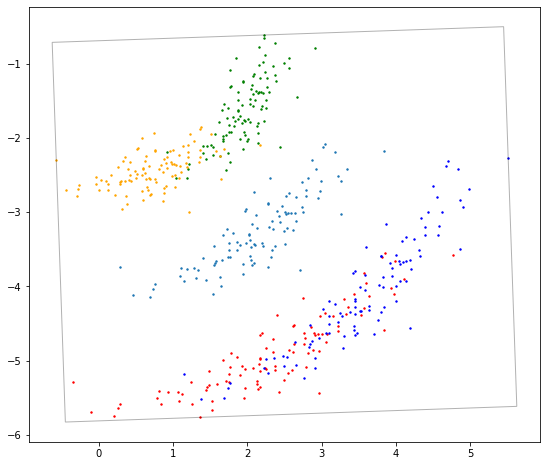

In [2]:
# Forming quadrilateral enclosing vertices of box.

def get_vertices_from_center(center, heading, lw):
    vertices = np.empty((8,))
    rot1 = np.array([
            [ np.cos(heading),  np.sin(heading)],
            [ np.sin(heading), -np.cos(heading)]])
    rot2 = np.array([
            [ np.cos(heading), -np.sin(heading)],
            [ np.sin(heading),  np.cos(heading)]])
    rot3 = np.array([
            [-np.cos(heading), -np.sin(heading)],
            [-np.sin(heading),  np.cos(heading)]])
    rot4 = np.array([
            [-np.cos(heading),  np.sin(heading)],
            [-np.sin(heading), -np.cos(heading)]])
    vertices[0:2] = center + 0.5 * rot1 @ lw
    vertices[2:4] = center + 0.5 * rot2 @ lw
    vertices[4:6] = center + 0.5 * rot3 @ lw
    vertices[6:8] = center + 0.5 * rot4 @ lw
    return vertices

def get_approx_union(theta, vertices):
    """Gets A_t, b_0 for the contraint set A_t x >= b_0
    vertices : np.array
        Vertices of shape (?, 8)
    
    Returns
    =======
    np.array
        A_t matrix of shape (4, 2)
    np.array
        b_0 vector of shape (4,)
    """
    At = np.array([
            [ np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]])
    At = np.concatenate((np.eye(2), -np.eye(2),)) @ At

    a0 = np.max(At @ vertices[:, 0:2].T, axis=1)
    a1 = np.max(At @ vertices[:, 2:4].T, axis=1)
    a2 = np.max(At @ vertices[:, 4:6].T, axis=1)
    a3 = np.max(At @ vertices[:, 6:8].T, axis=1)
    b0 = np.max(np.stack((a0, a1, a2, a3)), axis=0)
    return At, b0

def plot_h_polyhedron(ax, A, b, fc='none', ec='none', alpha=0.3):
    """
    A x < b is the H-representation
    [A; b], A x + b < 0 is the format for HalfspaceIntersection
    """
    Ab = np.concatenate((A, -b[...,None],), axis=-1)
    res = scipy.optimize.linprog([0, 0], A_ub=Ab[:,:2], b_ub=-Ab[:,2],
                                 bounds=(None, None))
    hs = scipy.spatial.HalfspaceIntersection(Ab, res.x)
    ch = scipy.spatial.ConvexHull(hs.intersections)
    x, y = zip(*hs.intersections[ch.vertices])
    ax.fill(x, y, fc=fc, ec=ec, alpha=0.3)

N = 100
lw = np.array([3.0, 1.5])
z = np.random.normal(loc=0., scale=0.5, size=(N,))
theta = (1/8 * np.pi) * z + np.pi + np.random.uniform(0., 2.)*np.pi
r = np.random.normal(loc=4., scale=0.2, size=(N,))
X = np.stack((r*np.cos(theta), r*np.sin(theta), theta), axis=1)


fig, ax = plt.subplots(figsize=(15,8))
axes = [ax]

axes[0].scatter(X[:,0], X[:,1], s=2)
axes[0].set_aspect('equal')

vertex_set = np.zeros((N, 8))
for idx in range(N):
    vertex_set[idx] = get_vertices_from_center(X[idx,:2], X[idx,2], lw)

X = vertex_set[:,0:2].T
axes[0].scatter(X[0], X[1], c='r', s=2)
X = vertex_set[:,2:4].T
axes[0].scatter(X[0], X[1], c='b', s=2)
X = vertex_set[:,4:6].T
axes[0].scatter(X[0], X[1], c='g', s=2)
X = vertex_set[:,6:8].T
axes[0].scatter(X[0], X[1], c='orange', s=2)
axes[0].set_aspect('equal')

"""Cluster the samples"""
mean_theta = np.mean(X[:,2])
A, b = get_approx_union(mean_theta, vertex_set)

plot_h_polyhedron(axes[0], A, b, ec='k', alpha=0.3)

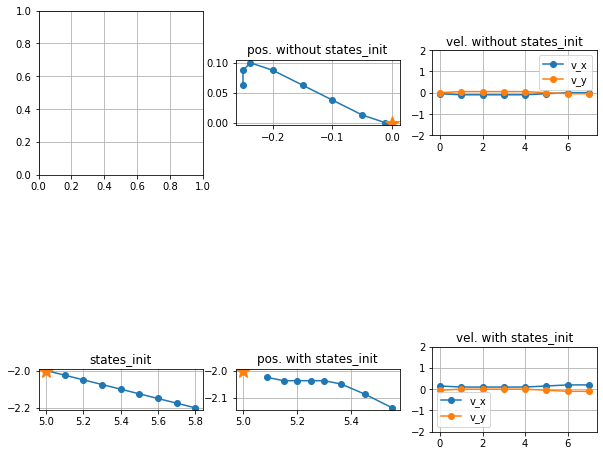

In [87]:
# Computing the states given state-space representation, and control inputs

Ts = 0.5
T = 8

# Heejin state-space representation.
A = np.diag([1, 1], k=2)
# B, sys.B both have shape (4, 2)
B = np.concatenate((np.diag([0,0]), np.diag([1,1]),))
# C has shape (2, 4)
C = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=1)
# D has shape (2, 2)
D = np.diag([0, 0])
sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)

A = np.array(sys.A)
B = np.array(sys.B)
nx, nu = sys.B.shape

p_0_x, p_0_y, v_0_x, v_0_y = 5,-2,0.2,-0.05
x0 = np.array([p_0_x, p_0_y, v_0_x, v_0_y])

# Closed form solution to states given inputs
# C1 has shape (nx, T*nx)
C1 = np.zeros((nx, T*nx,))
# C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
C2 = np.kron(np.eye(T - 1), A)
# C3 has shape (nx*(T - 1), nx)
C3 = np.zeros(((T - 1)*nx, nx,))
# C, Abar have shape (nx*T, nx*T)
C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
Abar = np.eye(T * nx) - C
# Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
Bbar = np.kron(np.eye(T), B)
# Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
Gamma = np.concatenate((np.zeros((nx, T*nu,)), np.linalg.solve(Abar, Bbar),))

# make state computation account for initial position and velocity
states_init = np.concatenate([np.linalg.matrix_power(A, t) @ x0 for t in range(T+1)])
Z = states_init

u = np.array([
    [-0.1, 0], # 0
    [-0.1, 0.1], # 1
    [ 0, 0], # 2
    [ 0, 0], # 3
    [ 0, 0], # 4
    [ 0.1, -0.1],
    [ 0.1, -0.1],
    [ 0, 0], # 7
])
u = u.ravel()

# Gamma is used translate the sequence of controls
# into position and velocity over timesteps 1..T
X = Gamma @ u
x1 = X[nx::nx]
x2 = X[nx + 1::nx]
x3 = X[nx + 2::nx]
x4 = X[nx + 3::nx]

fig, axes = plt.subplots(2, 3, figsize=(10,10))
axes = axes.ravel()

# plot points without states_init
axes[1].plot(x1, x2, '-o')
axes[1].plot(0, 0, '*', markersize=15)
axes[2].plot(range(T), x3, '-o', label='v_x')
axes[2].plot(range(T), x4, '-o', label='v_y')

X = Z + Gamma @ u
x1 = X[nx::nx]
x2 = X[nx + 1::nx]
x3 = X[nx + 2::nx]
x4 = X[nx + 3::nx]
Z = Z.reshape((-1,4))

# plot points with states_init
axes[3].plot(Z[:,0], Z[:,1], '-o')
axes[3].plot(x0[0], x0[1], '*', markersize=15)
axes[4].plot(x1, x2, '-o')
axes[4].plot(x0[0], x0[1], '*', markersize=15)
axes[5].plot(range(T), x3, '-o', label='v_x')
axes[5].plot(range(T), x4, '-o', label='v_y')

axes[1].set_title('pos. without states_init')
axes[2].set_title('vel. without states_init')
axes[3].set_title('states_init')
axes[4].set_title('pos. with states_init')
axes[5].set_title('vel. with states_init')

axes[2].legend()
axes[2].set_ylim([-2,2])

axes[5].legend()
axes[5].set_ylim([-2,2])

for ax in axes:
    ax.set_aspect('equal')
    ax.grid()